# Stroke Prediction
# Scott Breitbach
## 21-July-2022

In [1]:
## LOAD LIBRARIES
import pandas as pd
import numpy as np
from pandas.core.common import random_state
# plotting:
import matplotlib.pyplot as plt
import seaborn as sns
# encoding categorical variables
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import OneHotEncoder
# split dataset
from sklearn.model_selection import train_test_split
# data transformations
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import MinMaxScaler
# balancing data
from collections import Counter
import imblearn
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
# model comparison
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import matthews_corrcoef, roc_auc_score, recall_score
# classification models
from lightgbm import LGBMClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.tree import DecisionTreeClassifier
from xgboost.sklearn import XGBClassifier
# tuning and model ensembles
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import make_scorer

from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import StackingClassifier
from sklearn.ensemble import BaggingClassifier


# Load Data

In [2]:
# import files to colab
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

Saving train_strokes.csv to train_strokes (1).csv
User uploaded file "train_strokes.csv" with length 2635787 bytes


In [3]:
def load_dataframe(path):
  # load dataset as pandas DataFrame
  DF = pd.read_csv(path, index_col=0)
  return DF

# load the dataframe
strokeDF = load_dataframe('/content/train_strokes.csv')

# Look at data

In [4]:
# look at dataframe
strokeDF.head()

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
id,,,,,,,,,,,
30669,Male,3.0,0,0,No,children,Rural,95.12,18.0,NaN,0
30468,Male,58.0,1,0,Yes,Private,Urban,87.96,39.2,never smoked,0
16523,Female,8.0,0,0,No,Private,Urban,110.89,17.6,NaN,0
56543,Female,70.0,0,0,Yes,Private,Rural,69.04,35.9,formerly smoked,0
46136,Male,14.0,0,0,No,Never_worked,Rural,161.28,19.1,NaN,0


In [5]:
# display object types
strokeDF.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 43400 entries, 30669 to 36271
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   gender             43400 non-null  object 
 1   age                43400 non-null  float64
 2   hypertension       43400 non-null  int64  
 3   heart_disease      43400 non-null  int64  
 4   ever_married       43400 non-null  object 
 5   work_type          43400 non-null  object 
 6   Residence_type     43400 non-null  object 
 7   avg_glucose_level  43400 non-null  float64
 8   bmi                41938 non-null  float64
 9   smoking_status     30108 non-null  object 
 10  stroke             43400 non-null  int64  
dtypes: float64(3), int64(3), object(5)
memory usage: 4.0+ MB


In [6]:
# summarize numerical data
strokeDF.describe().T

,count,mean,std,min,25%,50%,75%,max
age,43400.0,42.217894,22.519649,0.08,24.00,44.00,60.00,82.00
hypertension,43400.0,0.093571,0.291235,0.00,0.00,0.00,0.00,1.00
heart_disease,43400.0,0.047512,0.212733,0.00,0.00,0.00,0.00,1.00
avg_glucose_level,43400.0,104.482750,43.111751,55.00,77.54,91.58,112.07,291.05
bmi,41938.0,28.605038,7.770020,10.10,23.20,27.70,32.90,97.60
stroke,43400.0,0.018041,0.133103,0.00,0.00,0.00,0.00,1.00


* Minimum `age` of 0.08 years (1 month) is unlikely to be correct. Will need to look at distribution and establish a cutoff.

* `hypertension` and `heart_disease` appear to already be scaled 0-1, which is probably fine.

* `avg_glucose_level` Note: "A blood sugar level less than 140 mg/dL (7.8 mmol/L) is normal. A reading of more than 200 mg/dL (11.1 mmol/L) after two hours indicates diabetes. A reading between 140 and 199 mg/dL (7.8 mmol/L and 11.0 mmol/L) indicates prediabetes." per [Mayo Clinic](https://www.mayoclinic.org/diseases-conditions/diabetes/diagnosis-treatment/drc-20371451)

* A minimum `bmi` of [10.10 is not entirely unreasonable](https://www.ennonline.net/fex/15/limits).

In [7]:
# summarize categorical data
strokeDF.describe(exclude=['float', 'int']).T

,count,unique,top,freq
gender,43400,3,Female,25665
ever_married,43400,2,Yes,27938
work_type,43400,5,Private,24834
Residence_type,43400,2,Urban,21756
smoking_status,30108,3,never smoked,16053


In [8]:
# show categories for each categorical column
for i in strokeDF.columns:
  if strokeDF[i].dtype == 'O':
    print(f'\n* {i}:')
    print(strokeDF[i].value_counts())


* gender:
Female    25665
Male      17724
Other        11
Name: gender, dtype: int64

* ever_married:
Yes    27938
No     15462
Name: ever_married, dtype: int64

* work_type:
Private          24834
Self-employed     6793
children          6156
Govt_job          5440
Never_worked       177
Name: work_type, dtype: int64

* Residence_type:
Urban    21756
Rural    21644
Name: Residence_type, dtype: int64

* smoking_status:
never smoked       16053
formerly smoked     7493
smokes              6562
Name: smoking_status, dtype: int64


In [9]:
# Count null values in each column
strokeDF.isna().sum()

gender                   0
age                      0
hypertension             0
heart_disease            0
ever_married             0
work_type                0
Residence_type           0
avg_glucose_level        0
bmi                   1462
smoking_status       13292
stroke                   0
dtype: int64

In [10]:
# how much of the data is Null
num = round(strokeDF.bmi.isna().sum() / len(strokeDF) * 100, 1)
print(f'{num}% of bmi data is Null')

num = round(strokeDF.smoking_status.isna().sum() / len(strokeDF) * 100, 1)
print(f'{num}% of smoking_status data is Null')

3.4% of bmi data is Null
30.6% of smoking_status data is Null


# Clean data

## Impute Null values in `smoking_status` to 'unknown'

In [11]:
# impute null smoking values to class 'unknown'
strokeDF['smoking_status'] = strokeDF['smoking_status'].fillna('unknown')
# confirm imputation
strokeDF.smoking_status.value_counts()

never smoked       16053
unknown            13292
formerly smoked     7493
smokes              6562
Name: smoking_status, dtype: int64

## Convert `smoking_status` categories to single word descriptors

In [12]:
# swap out to simpler smoking descriptions
strokeDF['smoking_status'].replace(['never smoked', 'formerly smoked', 'smokes'],
                                   ['never', 'former', 'smoker'], inplace=True)

# Look at distributions

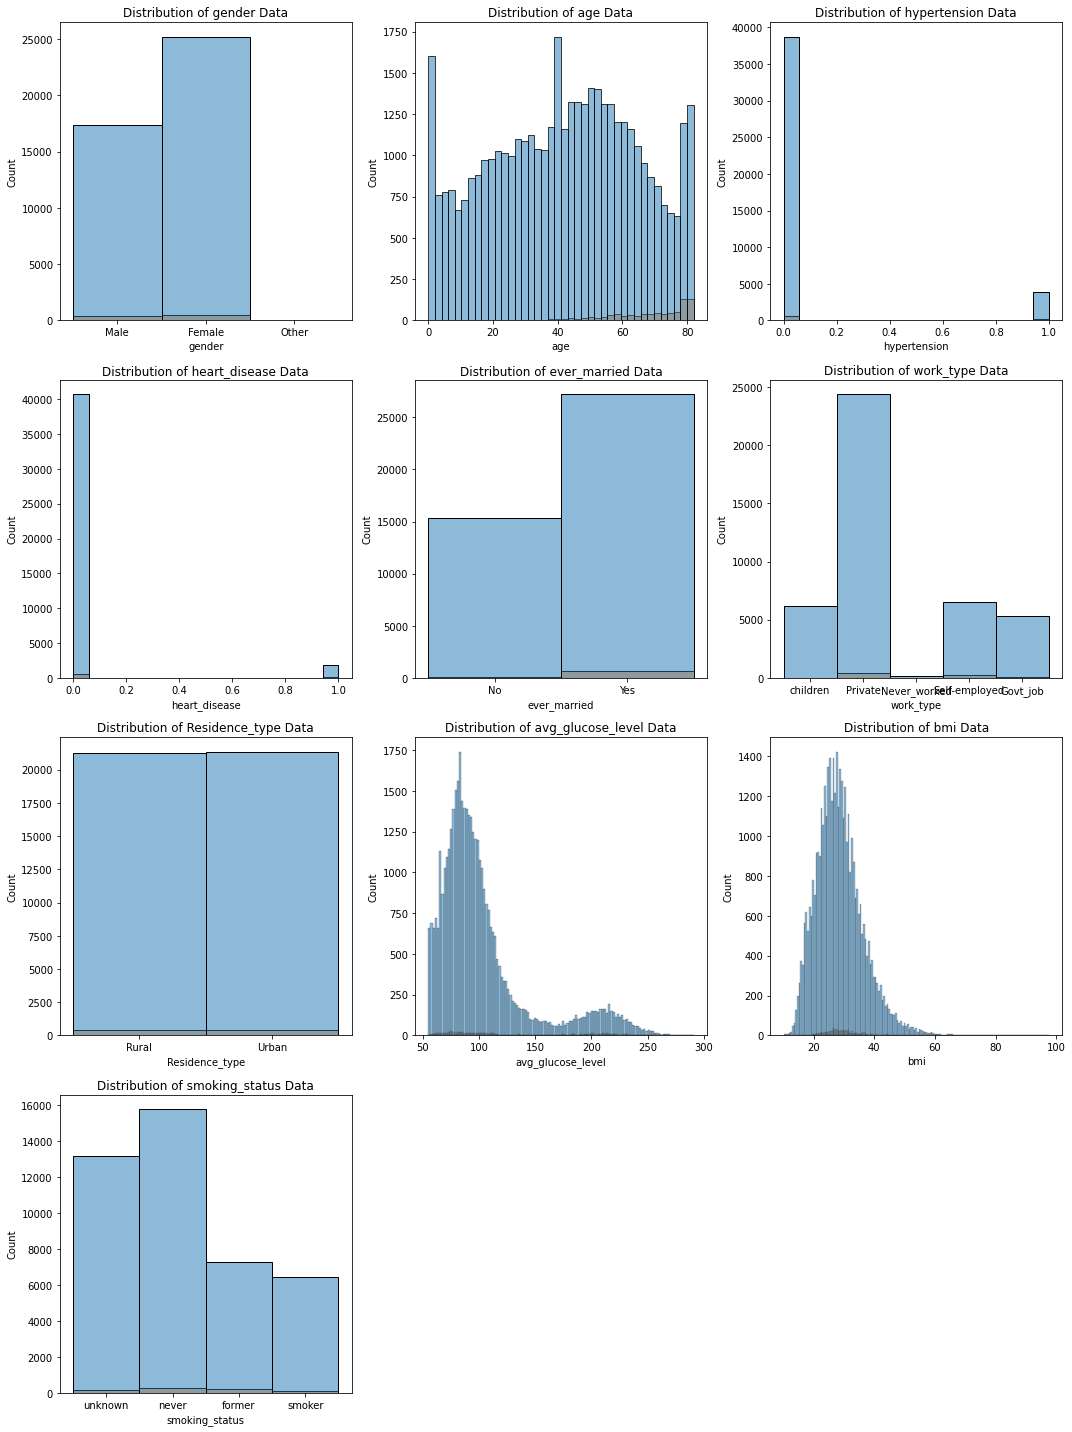

CPU times: user 4.49 s, sys: 213 ms, total: 4.7 s
Wall time: 4.63 s


In [13]:
%%time
# Look at histograms by variable
plt.figure(figsize=(15, 20))
for i, col in enumerate(strokeDF.columns[:-1], 1):
  plt.subplot(4, 3, i)
  plt.title(f'Distribution of {col} Data')
  sns.histplot(data=strokeDF, x=col, kde=False, hue='stroke', legend=False)
  plt.tight_layout()
  plt.plot()
plt.show()

### Things to fix:
* Remove 'Other' gender (only 11)? Maybe not, idk. Could simplfy to 1 column
* Fix 'age' outliers? Seems too many near 0; huge jump around 80?
* 'avg_glucose_level' and 'bmi' are skewed
* Huge imbalance in target variable 'stroke' (difficult to compare stroke vs non-stroke distributions). Balance training data

## Compare distributions with balanced dataset

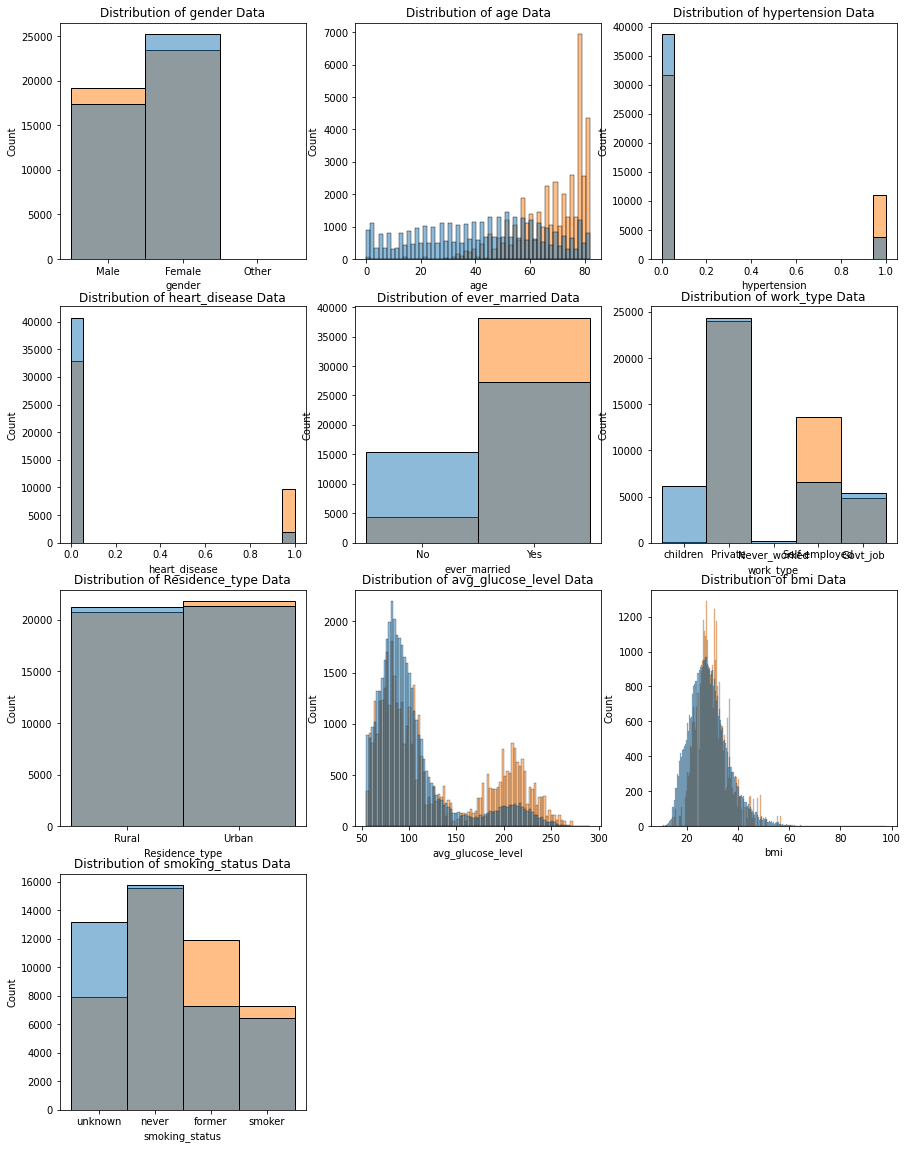

In [14]:
## BALANCE BASED ON TARGET (STROKE)
# define oversampling strategy
oversample = RandomOverSampler(sampling_strategy='minority', random_state=42)
# fit and apply the transform
y = strokeDF.stroke
X, y = oversample.fit_resample(strokeDF, y)


# Look at histograms by variable
plt.figure(figsize=(15, 20))
for i, col in enumerate(X.columns[:-1], 1):
  plt.subplot(4, 3, i)
  plt.title(f'Distribution of {col} Data')
  sns.histplot(data=X, x=col, kde=False, hue='stroke', legend=False)
  plt.plot()
plt.show()

### Feature Considerations:
* `work_status` 'Self_employed' shows higher stroke risk (and lower stroke risk for being a child). Possibly convert to 2 categories: self-employed vs other?  
* Very little difference in `Residence_type`. Remove feature?  
* `smoking_status`: stroke risk increased with smoking; combine smoker & former smoker and make 2 categories: smoke vs other?
* Very few young people are at risk for stroke (4 cases under age 30). Consider only using data from `age` > 30?

In [15]:
# look at stroke cases for < age 30
strokeDF[strokeDF.stroke == 1][strokeDF.age < 30]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
id,,,,,,,,,,,
69768,Female,1.32,0,0,No,children,Urban,70.37,NaN,unknown,1
49669,Female,14.00,0,0,No,children,Rural,57.93,30.9,unknown,1
71866,Male,21.00,0,0,No,Private,Rural,67.42,25.7,never,1
38112,Male,29.00,0,0,Yes,Private,Rural,60.72,NaN,former,1


Keep all data for now. Eliminate features later if it seems prudent.

## Impute Null values in `bmi` using median
Note: compared imputation with mean, median, and using logistic regression. All were relatively the same, but median generally performed best for most models (and is much simpler than regression).  
Note: while the right thing to do would be to impute using the median of the training data, there is very little difference overall when imputing with different values and median is unlikely to vary by much between overall and training datasets.

In [16]:
# impute missing 'bmi' values with median
strokeDF.bmi.fillna(strokeDF.bmi.median(), inplace=True)

In [17]:
# confirm no null values remaining
strokeDF.isna().sum()

gender               0
age                  0
hypertension         0
heart_disease        0
ever_married         0
work_type            0
Residence_type       0
avg_glucose_level    0
bmi                  0
smoking_status       0
stroke               0
dtype: int64

# Encode categorical variables

Okay, none of the 'Other' gender had a stroke and it's only 0.03% of the dataset, so I'm going to remove those 11 in the interest of simplifying and reducing overall complexity. Maybe this is an ethical concern to consider.

In [18]:
# make a copy of the data to go back to if needed
DF = strokeDF[strokeDF['gender'] != 'Other'].copy()

In [19]:
## ENCODE BINARY VALUES
# encode Yes/No to 1/0
DF.ever_married.replace(['Yes', 'No'], [1, 0], inplace=True)
# encode gender to 1/0
DF.gender.replace(['Male', 'Female'], [1, 0], inplace=True)
# encode Urban/Rural to 1/0
DF.Residence_type.replace(['Rural', 'Urban'], [1, 0], inplace=True)

In [20]:
## ONE HOT ENCODE CATEGORICAL VALUES
# one hot encode remaining categorical variables
transformer = make_column_transformer(
    (OneHotEncoder(), ['work_type', 'smoking_status']), 
    remainder='passthrough')
transformed = transformer.fit_transform(DF)
DF = pd.DataFrame(transformed, columns=transformer.get_feature_names_out(), 
                  index=DF.index) # fix index that was reset

# remove prefixes added by OneHotEncoder()
DF.columns = DF.columns.str.replace("onehotencoder__", "")
DF.columns = DF.columns.str.replace("remainder__", "")

# Train Test Split

In [21]:
## SEPARATE DATA FROM TARGET
X, y = DF.iloc[:,:-1], DF.iloc[:,-1]

## SPLIT TRAINING AND TEST SETS
X_train, X_test, y_train, y_test = train_test_split(
  X, y, test_size=0.33, random_state=42, 
  stratify=y) # stratify to maintain proportion of target variable

# Data transformation

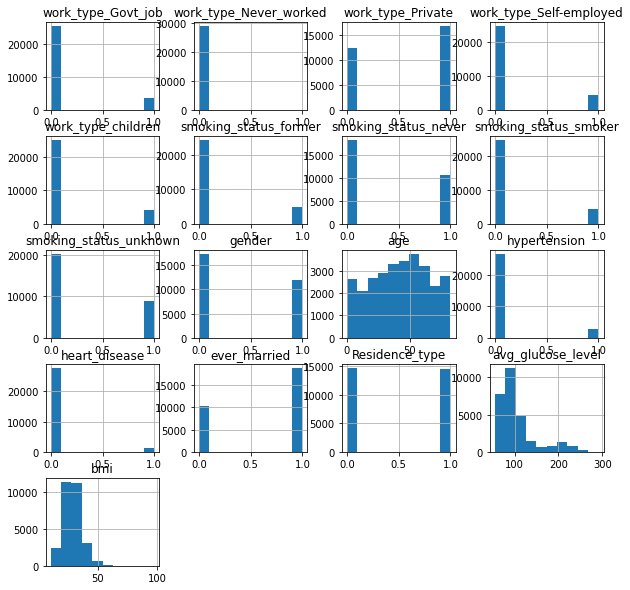

In [22]:
# Look at distributions pre-transformation
X_train.hist(figsize=(10,10))
plt.show()

In [23]:
## TRANSFORM FEATURES
# define the pipeline 
# (yes, I know a pipeline isn't needed for a single transformation)
power = PowerTransformer(method='box-cox')
pipeline = Pipeline(steps=[('p', power)])

# specify columns to box-cox transform
cols_to_transform = ['age', 'avg_glucose_level', 'bmi']
# transform features and apply to both train and test sets
for i in cols_to_transform:
  X_train[i] = pipeline.fit_transform(X_train[i].values.reshape(-1,1))
  X_test[i] = pipeline.transform(X_test[i].values.reshape(-1,1))

# scale entire dataset to the same range
scaler = MinMaxScaler(feature_range=(-1, 1))
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

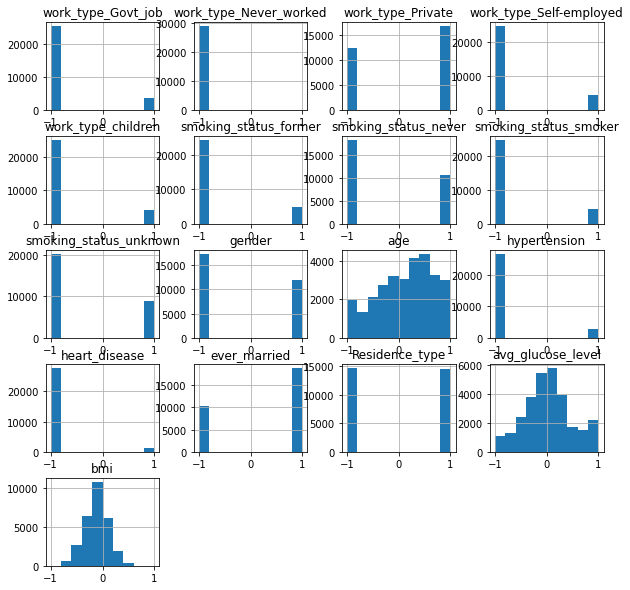

In [24]:
# Look at distributions post-transformation
dataset = pd.DataFrame(X_train, columns=DF.columns[:-1])
dataset.hist(figsize=(10,10))
plt.show()

# Balance Training dataset

In [25]:
## BALANCE BASED ON TARGET (STROKE)
# define oversampling strategy
oversample = RandomOverSampler(sampling_strategy='minority', 
                              #  sampling_strategy=0.5, # sample to 50%
                                random_state=42)
# fit and apply the transform
X_over, y_over = oversample.fit_resample(X_train, y_train)

## Try balancing using SMOTE

In [26]:
# summarize target class distribution
counter = Counter(y_train)
print(counter)

Counter({0.0: 28545, 1.0: 525})


In [27]:
# define oversampling strategy
oversample = SMOTE(sampling_strategy='minority',
                   random_state=42)
# fit and apply the transform
X_smote, y_smote = oversample.fit_resample(X_train, y_train)

# summarize target class distribution
counter = Counter(y_smote)
print(counter)

Counter({0.0: 28545, 1.0: 28545})


## Oversample SMOTE, then undersample majority

In [28]:
# define oversampling strategy
over = SMOTE(sampling_strategy=0.1, # upsample to 10% of majority
             random_state=42)
# define undersampling strategy
under = RandomUnderSampler(sampling_strategy=0.5, # sample to 50% ratio
                           random_state=42)
# define pipeline
steps = [('o', over), ('u', under)]
pipeline = Pipeline(steps=steps)
# fit and apply the transform
X_ou_smote, y_ou_smote = pipeline.fit_resample(X_train, y_train)

# [Compare Classification Methods](https://scikit-learn.org/stable/auto_examples/classification/plot_classifier_comparison.html)
Using Imbalanced target

In [29]:
# Set up DataFrame to store comparisons
model_compare = pd.DataFrame()

def get_model_metrics(name, model):
  '''Prints confusion matrix and some metrics; returns metrics in a DF'''
  cols = ['Model', 'Accuracy', 'F1_Score', 'Precision', 'Recall', 'MCC', 'AUC'] 
  # get predictions
  predictions = model.predict(X_test)
  
  # print confusion matrix
  cm = confusion_matrix(y_test, predictions)
  disp = ConfusionMatrixDisplay(confusion_matrix=cm, 
                                display_labels=model.classes_)
  print(cm)
  disp.plot()
  plt.show()  
  
  # get accuracy, f1-score, precision, and recall
  # accuracy = round(model.score(X_test, y_test)*100, 2)
  cr = classification_report(y_test, predictions, output_dict=True)
  accuracy = round(cr['accuracy']*100, 2)
  print('Accuracy: ', accuracy)
  f1Score = round(cr['1.0']['f1-score'], 4)
  print('F1-Score: ', f1Score)
  precision = round(cr['1.0']['precision'], 4)
  print('Precision:', precision)
  recall = round(cr['1.0']['recall'], 4)
  print('Recall:   ', recall)
  MCC = round(matthews_corrcoef(y_test, predictions), 4)
  print('MCC:      ', MCC)
  # weighted AUC
  AUC = round(roc_auc_score(y_test, predictions, average='weighted'), 4)
  print('AUC:      ', AUC)

  df = pd.DataFrame([[name, accuracy, f1Score, precision, recall, MCC, AUC]], 
                    columns=cols)
  return df

## [Random Forest](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html)

In [30]:
%%time
# Create classifier
rfClass = RandomForestClassifier(class_weight='balanced')

# Train model
rfClass.fit(X_train, y_train)

CPU times: user 2.22 s, sys: 25.3 ms, total: 2.24 s
Wall time: 2.23 s


[[14057     4]
 [  257     1]]


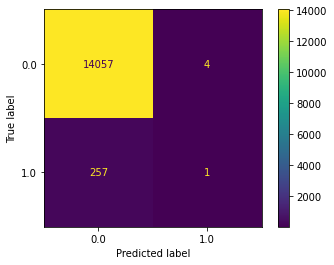

Accuracy:  98.18
F1-Score:  0.0076
Precision: 0.2
Recall:    0.0039
MCC:       0.0256
AUC:       0.5018


In [31]:
# Evaluate model
tempDF = get_model_metrics('RandomForest', rfClass)
# Store metrics
model_compare = pd.concat([model_compare, tempDF], ignore_index=True)

## [Decision Tree](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html)

In [32]:
%%time
# Create decision tree regressor object
decisiontree = DecisionTreeClassifier(class_weight='balanced')

# Train model
decisiontree.fit(X_train, y_train)

CPU times: user 106 ms, sys: 2.01 ms, total: 108 ms
Wall time: 109 ms


[[13821   240]
 [  235    23]]


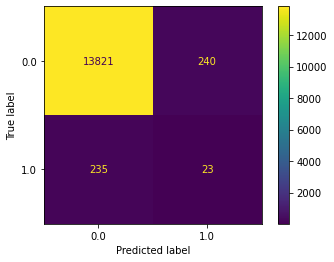

Accuracy:  96.68
F1-Score:  0.0883
Precision: 0.0875
Recall:    0.0891
MCC:       0.0714
AUC:       0.536


In [33]:
# Evaluate model
tempDF = get_model_metrics('DecisionTree', decisiontree)
# Store metrics
model_compare = pd.concat([model_compare, tempDF], ignore_index=True)

## [Logistic Regression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html)

In [34]:
%%time
# Create logistic regression
logit = LogisticRegression(class_weight='balanced')

# Train model
logit.fit(X_train, y_train)

CPU times: user 568 ms, sys: 338 ms, total: 905 ms
Wall time: 497 ms


[[10391  3670]
 [   48   210]]


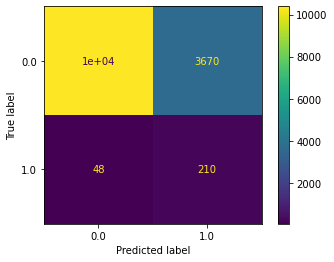

Accuracy:  74.03
F1-Score:  0.1015
Precision: 0.0541
Recall:    0.814
MCC:       0.1655
AUC:       0.7765


In [35]:
# Evaluate model
tempDF = get_model_metrics('LogReg_lbfgs', logit)
# Store metrics
model_compare = pd.concat([model_compare, tempDF], ignore_index=True)

In [36]:
%%time
# Load libraries
from sklearn.linear_model import LogisticRegression

# Create logistic regression
logit = LogisticRegression(class_weight='balanced',
                           solver='liblinear')

# Train model
logit.fit(X_train, y_train)

CPU times: user 260 ms, sys: 5.82 ms, total: 266 ms
Wall time: 273 ms


[[10391  3670]
 [   48   210]]


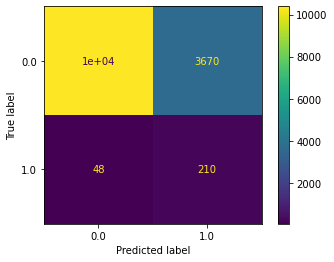

Accuracy:  74.03
F1-Score:  0.1015
Precision: 0.0541
Recall:    0.814
MCC:       0.1655
AUC:       0.7765


In [37]:
# Evaluate model
tempDF = get_model_metrics('LogReg_liblinear', logit)
# Store metrics
model_compare = pd.concat([model_compare, tempDF], ignore_index=True)

## [Gaussian Naive Bayes Classifier](https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.GaussianNB.html)

In [38]:
%%time
# Create Gaussian naive Bayes object
nBayes = GaussianNB()

# Fit model
nBayes.fit(X_train, y_train)

CPU times: user 14.1 ms, sys: 1.01 ms, total: 15.1 ms
Wall time: 16.1 ms


[[ 2966 11095]
 [    2   256]]


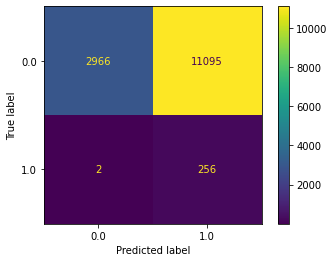

Accuracy:  22.5
F1-Score:  0.0441
Precision: 0.0226
Recall:    0.9922
MCC:       0.0667
AUC:       0.6016


In [39]:
# Evaluate model
tempDF = get_model_metrics('GaussianNB', nBayes)
# Store metrics
model_compare = pd.concat([model_compare, tempDF], ignore_index=True)

In [40]:
%%time
# Load libraries
from sklearn.naive_bayes import BernoulliNB

# Create Gaussian naive Bayes object
nBayes = BernoulliNB()

# Fit model
nBayes.fit(X_train, y_train)

CPU times: user 24.7 ms, sys: 1.9 ms, total: 26.6 ms
Wall time: 33.5 ms


[[13961   100]
 [  252     6]]


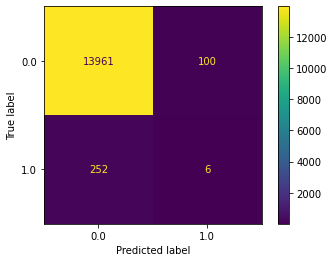

Accuracy:  97.54
F1-Score:  0.033
Precision: 0.0566
Recall:    0.0233
MCC:       0.0251
AUC:       0.5081


In [41]:
# Evaluate model
tempDF = get_model_metrics('BernoulliNB', nBayes)
# Store metrics
model_compare = pd.concat([model_compare, tempDF], ignore_index=True)

## [Support Vector Classifier (SVC)](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html)

In [42]:
%%time
# Create classification model
svc = SVC(class_weight='balanced')

# Fit model
svc.fit(X_train, y_train)

CPU times: user 31.3 s, sys: 320 ms, total: 31.6 s
Wall time: 31.5 s


[[10656  3405]
 [   68   190]]


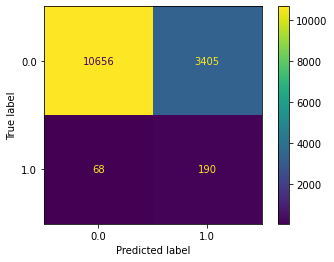

Accuracy:  75.75
F1-Score:  0.0986
Precision: 0.0529
Recall:    0.7364
MCC:       0.1516
AUC:       0.7471


In [43]:
# Evaluate model
tempDF = get_model_metrics('SVC', svc)
# Store metrics
model_compare = pd.concat([model_compare, tempDF], ignore_index=True)

## [Linear SVC](https://scikit-learn.org/stable/modules/generated/sklearn.svm.LinearSVC.html)

In [44]:
%%time
# Create classification model
linSVC = LinearSVC(class_weight='balanced')

# Fit model
linSVC.fit(X_train, y_train)

CPU times: user 4.63 s, sys: 16.5 ms, total: 4.65 s
Wall time: 4.64 s


/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


[[10668  3393]
 [   58   200]]


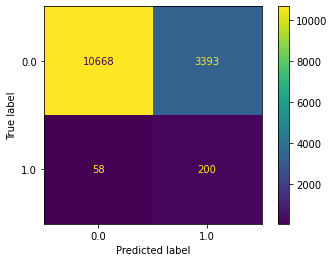

Accuracy:  75.9
F1-Score:  0.1039
Precision: 0.0557
Recall:    0.7752
MCC:       0.1638
AUC:       0.7669


In [45]:
# Evaluate model
tempDF = get_model_metrics('LinearSVC', linSVC)
# Store metrics
model_compare = pd.concat([model_compare, tempDF], ignore_index=True)

## [Ada Boost Classifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.AdaBoostClassifier.html)

In [46]:
%%time
# Create classifier
adaboost = AdaBoostClassifier()

# Train model
adaboost.fit(X_train, y_train)

CPU times: user 1.17 s, sys: 9.91 ms, total: 1.18 s
Wall time: 1.17 s


[[14060     1]
 [  258     0]]


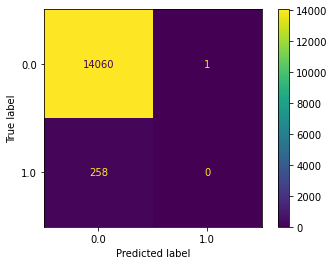

Accuracy:  98.19
F1-Score:  0.0
Precision: 0.0
Recall:    0.0
MCC:       -0.0011
AUC:       0.5


In [47]:
# Evaluate model
tempDF = get_model_metrics('AdaBoost', adaboost)
# Store metrics
model_compare = pd.concat([model_compare, tempDF], ignore_index=True)

## [MLP Classifier](https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html)

In [48]:
%%time
# Create classification model
mlp = MLPClassifier(early_stopping=True)

# Fit model
mlp.fit(X_train, y_train)

CPU times: user 2.48 s, sys: 1.75 s, total: 4.24 s
Wall time: 2.26 s


[[14061     0]
 [  258     0]]


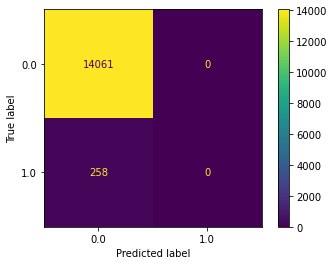

Accuracy:  98.2
F1-Score:  0.0
Precision: 0.0
Recall:    0.0
MCC:       0.0
AUC:       0.5


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [49]:
# Evaluate model
tempDF = get_model_metrics('MLP', mlp)
# Store metrics
model_compare = pd.concat([model_compare, tempDF], ignore_index=True)

## [Gradient Boosting Classifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html)

In [50]:
%%time
# Create classification model
gbc = GradientBoostingClassifier()

# Fit model
gbc.fit(X_train, y_train)

CPU times: user 3.54 s, sys: 8.64 ms, total: 3.55 s
Wall time: 3.55 s


[[14053     8]
 [  258     0]]


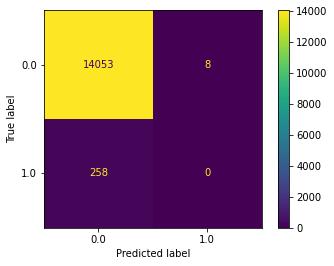

Accuracy:  98.14
F1-Score:  0.0
Precision: 0.0
Recall:    0.0
MCC:       -0.0032
AUC:       0.4997


In [51]:
# Evaluate model
tempDF = get_model_metrics('GBC', gbc)
# Store metrics
model_compare = pd.concat([model_compare, tempDF], ignore_index=True)

## [K-Nearest Neighbor](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html)

In [52]:
%%time
# Create classification model
knn = KNeighborsClassifier(2)

# Fit model
knn.fit(X_train, y_train)

CPU times: user 6.99 ms, sys: 1.11 ms, total: 8.1 ms
Wall time: 6.78 ms


[[14046    15]
 [  257     1]]


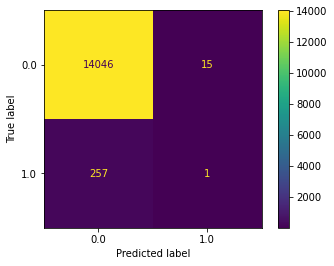

Accuracy:  98.1
F1-Score:  0.0073
Precision: 0.0625
Recall:    0.0039
MCC:       0.0112
AUC:       0.5014


In [53]:
# Evaluate model
tempDF = get_model_metrics('KNN', knn)
# Store metrics
model_compare = pd.concat([model_compare, tempDF], ignore_index=True)

## [Stochastic Gradient Descent](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html)

In [54]:
%%time
# Create classification model
sgd = SGDClassifier(class_weight='balanced')

# Fit model
sgd.fit(X_train, y_train)

CPU times: user 243 ms, sys: 2.17 ms, total: 245 ms
Wall time: 246 ms


[[12413  1648]
 [  153   105]]


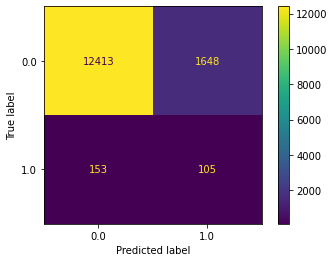

Accuracy:  87.42
F1-Score:  0.1044
Precision: 0.0599
Recall:    0.407
MCC:       0.1176
AUC:       0.6449


In [55]:
# Evaluate model
tempDF = get_model_metrics('SGD', sgd)
# Store metrics
model_compare = pd.concat([model_compare, tempDF], ignore_index=True)

## [LGBM Classifier](https://lightgbm.readthedocs.io/en/latest/pythonapi/lightgbm.LGBMClassifier.html)

In [56]:
%%time
# Create classification model
lgbm = LGBMClassifier(class_weight='balanced')

# Fit model
lgbm.fit(X_train, y_train)

CPU times: user 1.5 s, sys: 26.3 ms, total: 1.53 s
Wall time: 1.62 s


[[12363  1698]
 [  141   117]]


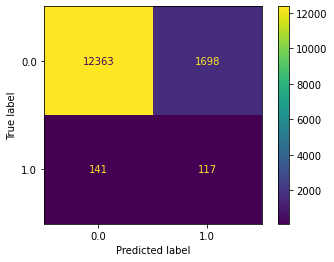

Accuracy:  87.16
F1-Score:  0.1129
Precision: 0.0645
Recall:    0.4535
MCC:       0.133
AUC:       0.6664


In [57]:
# Evaluate model
tempDF = get_model_metrics('LGBM', lgbm)
# Store metrics
model_compare = pd.concat([model_compare, tempDF], ignore_index=True)

## [XGBoost Classifier](https://xgboost.readthedocs.io/en/stable/python/python_api.html)

In [58]:
%%time
# Create classification model
xgbc = XGBClassifier(class_weight='balanced')

# Fit model
xgbc.fit(X_train, y_train)

CPU times: user 1.9 s, sys: 18.7 ms, total: 1.92 s
Wall time: 1.91 s


[[14061     0]
 [  258     0]]


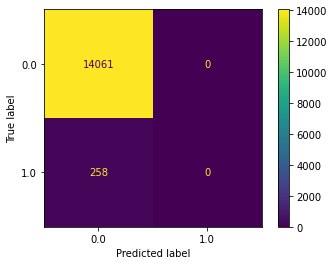

Accuracy:  98.2
F1-Score:  0.0
Precision: 0.0
Recall:    0.0
MCC:       0.0
AUC:       0.5


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [59]:
# Evaluate model
tempDF = get_model_metrics('XGBC', xgbc)
# Store metrics
model_compare = pd.concat([model_compare, tempDF], ignore_index=True)

## [Linear Discriminant Analysis](https://scikit-learn.org/stable/modules/generated/sklearn.discriminant_analysis.LinearDiscriminantAnalysis.html)

In [60]:
%%time
# Create classification model
lda = LinearDiscriminantAnalysis()

# Fit model
lda.fit(X_train, y_train)

CPU times: user 84.9 ms, sys: 9.99 ms, total: 94.9 ms
Wall time: 88.3 ms


[[13895   166]
 [  236    22]]


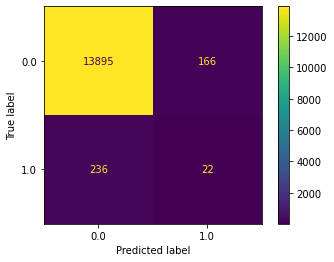

Accuracy:  97.19
F1-Score:  0.0987
Precision: 0.117
Recall:    0.0853
MCC:       0.0858
AUC:       0.5367


In [61]:
# Evaluate model
tempDF = get_model_metrics('LDA', lda)
# Store metrics
model_compare = pd.concat([model_compare, tempDF], ignore_index=True)

## Compare Model Performance

In [62]:
# compare model metrics
model_compare.sort_values('MCC', ascending=False, ignore_index=True)

,Model,Accuracy,F1_Score,Precision,Recall,MCC,AUC
0,LogReg_lbfgs,74.03,0.1015,0.0541,0.8140,0.1655,0.7765
1,LogReg_liblinear,74.03,0.1015,0.0541,0.8140,0.1655,0.7765
2,LinearSVC,75.90,0.1039,0.0557,0.7752,0.1638,0.7669
3,SVC,75.75,0.0986,0.0529,0.7364,0.1516,0.7471
4,LGBM,87.16,0.1129,0.0645,0.4535,0.1330,0.6664
5,SGD,87.42,0.1044,0.0599,0.4070,0.1176,0.6449
6,LDA,97.19,0.0987,0.1170,0.0853,0.0858,0.5367
7,DecisionTree,96.68,0.0883,0.0875,0.0891,0.0714,0.5360
8,GaussianNB,22.50,0.0441,0.0226,0.9922,0.0667,0.6016
9,RandomForest,98.18,0.0076,0.2000,0.0039,0.0256,0.5018


In [63]:
# filter higher MCC and sort by Recall
table = model_compare.sort_values('MCC', ascending=False, ignore_index=True)
table[table['MCC'] > 0.15].sort_values('Recall', ascending=False)

,Model,Accuracy,F1_Score,Precision,Recall,MCC,AUC
0,LogReg_lbfgs,74.03,0.1015,0.0541,0.8140,0.1655,0.7765
1,LogReg_liblinear,74.03,0.1015,0.0541,0.8140,0.1655,0.7765
2,LinearSVC,75.90,0.1039,0.0557,0.7752,0.1638,0.7669
3,SVC,75.75,0.0986,0.0529,0.7364,0.1516,0.7471


## Hyperparameter Tuning

In [64]:
# set up scorer using Matthews Correlation Coefficient
mcc = make_scorer(matthews_corrcoef)

### Logistic Regression

In [65]:
# Create classifier
logit = LogisticRegression(class_weight='balanced',
                           random_state=42, max_iter=500)

# Get a baseline model
baseline = logit.fit(X_train, y_train)

# Create range of candidate penalty hyperparameter values
parameter_space = {
    'penalty': ['l2', 'l1'],# 'none', 'elasticnet'],
    'tol': [1e-7, 1e-5], #, 1e-3
    'C': [0.1, 1], #, 10
    'solver': ['liblinear', 'lbfgs', 'sag', 'saga']#,'newton-cg']
}

# Set up grid search
grid = GridSearchCV(logit, parameter_space, scoring=mcc, cv=5)

In [1]:
# %%time
# # Fit models
# grid_result = grid.fit(X_train, y_train)

In [67]:
# Show best parameters
print('Best parameters found:\n', grid_result.best_params_, '\n')
# Get accuracy scores
baseScore = round(baseline.score(X_test, y_test)*100, 2)
score = round(grid_result.score(X_test, y_test)*100, 2)
print(f"Baseline Accuracy:\t{baseScore}")
print(f"Tuned Accuracy:\t\t{score}")

Best parameters found:
 {'C': 0.1, 'penalty': 'l2', 'solver': 'lbfgs', 'tol': 1e-07} 

Baseline Accuracy:	74.03
Tuned Accuracy:		16.54


Evaluate tuned parameters

[[10387  3674]
 [   48   210]]


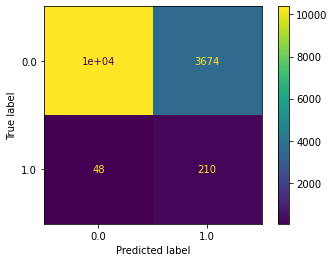

Accuracy:  74.01
F1-Score:  0.1014
Precision: 0.0541
Recall:    0.814
MCC:       0.1653
AUC:       0.7763
CPU times: user 498 ms, sys: 168 ms, total: 666 ms
Wall time: 498 ms


In [68]:
%%time
# Create logistic regression
logit = LogisticRegression(class_weight='balanced',
                           C=0.1, penalty='l2', solver='liblinear', tol=1e-7,
                           random_state=42, max_iter=500)
# Train model
logit.fit(X_train, y_train)

# Evaluate model
get_model_metrics('LogReg', logit)

### Linear SVC

In [69]:
# Create classifier
linSVC = LinearSVC(class_weight='balanced',
                   max_iter=2000,
                   random_state=42)

# Get a baseline model
baseline = linSVC.fit(X_train, y_train)

# Create range of candidate penalty hyperparameter values
parameter_space = {
    'penalty': ['l2', 'l1'],
    'loss': ['squared_hinge'], #'hinge', 
    'dual': [True, False],
    'tol': [1e-8, 1e-6, 1e-4],
    'C': [1, 10, 100] # 0.1, 
}
# Set up grid search
grid = GridSearchCV(linSVC, parameter_space, scoring=mcc, cv=5)

/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


In [2]:
# %%time
# # Fit models
# grid_result = grid.fit(X_train, y_train)

In [71]:
# Show best parameters
print('Best parameters found:\n', grid_result.best_params_, '\n')
# Get accuracy scores
baseScore = round(baseline.score(X_test, y_test)*100, 2)
score = round(grid_result.score(X_test, y_test)*100, 2)
print(f"Baseline Accuracy:\t{baseScore}")
print(f"Tuned Accuracy:\t\t{score}")

Best parameters found:
 {'C': 10, 'dual': False, 'loss': 'squared_hinge', 'penalty': 'l2', 'tol': 1e-08} 

Baseline Accuracy:	73.55
Tuned Accuracy:		16.36


Evaluate tuned parameters

[[10269  3792]
 [   46   212]]


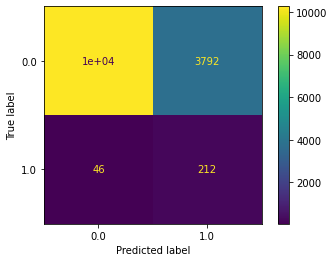

Accuracy:  73.2
F1-Score:  0.0995
Precision: 0.0529
Recall:    0.8217
MCC:       0.1636
AUC:       0.776
CPU times: user 544 ms, sys: 165 ms, total: 710 ms
Wall time: 533 ms


In [72]:
%%time
# Create classification model
linSVC = LinearSVC(class_weight='balanced',
                   C=10, dual=False, loss='squared_hinge', 
                   penalty='l2', tol=1e-8)

# Fit model
linSVC.fit(X_train, y_train)

# Evaluate model
get_model_metrics('LinSVC', linSVC)

### Support Vector Classifier (SVC)

In [73]:
# Create classifier
svc = SVC(class_weight='balanced',
          random_state=42)

# Get a baseline model
baseline = svc.fit(X_train, y_train)

# Create range of candidate penalty hyperparameter values
parameter_space = {
    'kernel': ['linear'],# 'poly', 'rbf', 'sigmoid'], # follow up w/other params
    'C': [10, 100], #0.1, 1, 
    # 'gamma': ['scale', 'auto'],
    # 'shrinking': [True, False],
    # 'probability': [True, False],
    'tol': [1e-3, 1e-2] # 1e-4, 0.1
}
# Set up grid search
grid = GridSearchCV(svc, parameter_space, scoring=mcc, cv=5)
# grid = RandomizedSearchCV(svc, parameter_space, scoring=mcc, 
#                           cv=5, n_iter=30, random_state=42)

In [74]:
%%time
# Fit models
grid_result = grid.fit(X_train, y_train)

CPU times: user 19min 53s, sys: 2.65 s, total: 19min 55s
Wall time: 19min 48s


In [75]:
# Show best parameters
print('Best parameters found:\n', grid_result.best_params_, '\n')
# Get accuracy scores
baseScore = round(baseline.score(X_test, y_test)*100, 2)
score = round(grid_result.score(X_test, y_test)*100, 2)
print(f"Baseline Accuracy:\t{baseScore}")
print(f"Tuned Accuracy:\t\t{score}")

Best parameters found:
 {'C': 100, 'kernel': 'linear', 'tol': 0.01} 

Baseline Accuracy:	75.75
Tuned Accuracy:		16.17


Evaluate tuned parameters

[[10213  3848]
 [   46   212]]


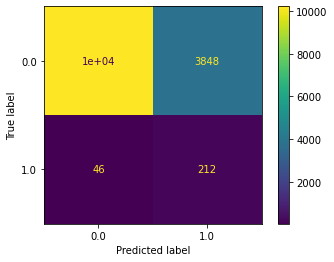

Accuracy:  72.81
F1-Score:  0.0982
Precision: 0.0522
Recall:    0.8217
MCC:       0.1617
AUC:       0.774
CPU times: user 1min 58s, sys: 183 ms, total: 1min 58s
Wall time: 1min 58s


In [76]:
%%time
# Load libraries
from sklearn.svm import SVC

# Create classification model
svc = SVC(class_weight='balanced',
          kernel='linear', C=100, tol=0.01,
          random_state=42)

# Fit model
svc.fit(X_train, y_train)

# Evaluate model
get_model_metrics('SVC', svc)

### Stochastic Gradient Descent

In [77]:
# Create classifier
sgd = SGDClassifier(class_weight='balanced',
                    max_iter=2000,
                    early_stopping=True,
                    random_state=42)

# Get a baseline model
baseline = sgd.fit(X_train, y_train)

# Create range of candidate penalty hyperparameter values
parameter_space = {
    'loss': ['hinge', 'log_loss', 'log', 'modified_huber', 'squared_hinge',
             'perceptron', 'squared_error', 'huber', 'epsilon_insensitive',
             'squared_epsilon_insensitive'],
    'penalty': ['l2', 'l1'],
    'alpha': [1e-5, 1e-4, 1e-3],
    'tol': [1e-9, 1e-8, 1e-7],#, 1e-3, 1e-6
    'epsilon': [0.0001, 0.001, 0.01],# , 1, 0.1
    'learning_rate': ['constant', 'optimal', 'invscaling', 'adaptive']
}
# Set up grid search
grid = GridSearchCV(sgd, parameter_space, scoring=mcc, cv=5)

In [3]:
# %%time
# # Fit models
# grid_result = grid.fit(X_train, y_train)

In [79]:
# Show best parameters
print('Best parameters found:\n', grid_result.best_params_, '\n')
# Get accuracy scores
baseScore = round(baseline.score(X_test, y_test)*100, 2)
score = round(grid_result.score(X_test, y_test)*100, 2)
print(f"Baseline Accuracy:\t{baseScore}")
print(f"Tuned Accuracy:\t\t{score}")

Best parameters found:
 {'alpha': 0.0001, 'epsilon': 0.01, 'learning_rate': 'optimal', 'loss': 'huber', 'penalty': 'l2', 'tol': 1e-09} 

Baseline Accuracy:	80.45
Tuned Accuracy:		15.3


Evaluate tuned parameters

[[9527 4534]
 [  35  223]]


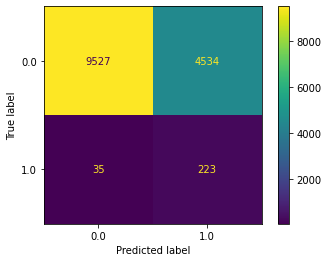

Accuracy:  68.09
F1-Score:  0.0889
Precision: 0.0469
Recall:    0.8643
MCC:       0.153
AUC:       0.7709
CPU times: user 403 ms, sys: 200 ms, total: 603 ms
Wall time: 407 ms


In [80]:
%%time
# Load libraries
from sklearn.linear_model import SGDClassifier

# Create classification model
sgd = SGDClassifier(class_weight='balanced',
                    alpha=0.0001, epsilon=0.01, learning_rate='optimal',
                    loss='huber', penalty='l2', tol=1e-9,
                    max_iter=2000,
                    early_stopping=True,
                    random_state=42)

# Fit model
sgd.fit(X_train, y_train)

# Evaluate model
get_model_metrics('SGD', sgd)

## Hyperparameter Tuning using multiple metrics

In [81]:
# Set up metrics to use for scoring
mcc = make_scorer(matthews_corrcoef)
scoring = {'MCC': mcc, 'Recall': 'recall', 'AUC': 'roc_auc'}

### Logistic Regression

In [82]:
# Create classifier
logit = LogisticRegression(class_weight='balanced',
                           random_state=42, max_iter=500)

# Get a baseline model
baseline = logit.fit(X_train, y_train)

# Create range of candidate penalty hyperparameter values
parameter_space = {
    'penalty': ['l2', 'l1'], #'none', 
    'tol': [1e-7, 1e-5], #, 1e-3
    'C': [0.1, 1], #, 10
    'solver': ['liblinear', 'lbfgs', 'sag', 'saga']
}
# Set up grid search
grid = GridSearchCV(logit, parameter_space, scoring=scoring, cv=5,
                    refit='MCC', return_train_score=True)

In [4]:
# %%time
# # Fit models
# grid_result = grid.fit(X_train, y_train)

In [84]:
# Show best parameters
print('Best parameters found:\n', grid_result.best_params_, '\n')
# Get accuracy scores
baseScore = round(baseline.score(X_test, y_test)*100, 2)
score = round(grid_result.score(X_test, y_test)*100, 2)
print(f"Baseline Accuracy:\t{baseScore}")
print(f"Tuned Accuracy:\t\t{score}")

Best parameters found:
 {'C': 0.1, 'penalty': 'l2', 'solver': 'lbfgs', 'tol': 1e-07} 

Baseline Accuracy:	74.03
Tuned Accuracy:		16.54


Evaluate tuned parameters

[[10387  3674]
 [   48   210]]


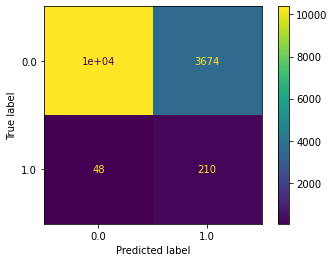

Accuracy:  74.01
F1-Score:  0.1014
Precision: 0.0541
Recall:    0.814
MCC:       0.1653
AUC:       0.7763
CPU times: user 496 ms, sys: 166 ms, total: 662 ms
Wall time: 482 ms


In [85]:
%%time
# Create logistic regression
logit = LogisticRegression(class_weight='balanced',
                           penalty='l2', solver='liblinear', 
                           tol=1e-7, C=0.1,
                           random_state=42, max_iter=500)
# Train model
logit.fit(X_train, y_train)

# Evaluate model
get_model_metrics('LogReg', logit)

### Linear SVC

In [86]:
# Create classifier
linSVC = LinearSVC(class_weight='balanced',
                   max_iter=2000,
                   random_state=42)

# Get a baseline model
baseline = linSVC.fit(X_train, y_train)

# Create range of candidate penalty hyperparameter values
parameter_space = {
    'penalty': ['l2', 'l1'],
    'loss': ['squared_hinge'], #'hinge', 
    'dual': [True, False],
    'tol': [1e-8, 1e-6, 1e-4],
    'C': [1, 10, 100]
}
# Evaluate tuned parameters
grid = GridSearchCV(linSVC, parameter_space, scoring=scoring, cv=5,
                    refit='MCC', return_train_score=True)

/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


In [5]:
# %%time
# # Fit models
# grid_result = grid.fit(X_train, y_train)

In [88]:
# Show best parameters
print('Best parameters found:\n', grid_result.best_params_, '\n')
# Get accuracy scores
baseScore = round(baseline.score(X_test, y_test)*100, 2)
score = round(grid_result.score(X_test, y_test)*100, 2)
print(f"Baseline Accuracy:\t{baseScore}")
print(f"Tuned Accuracy:\t\t{score}")

Best parameters found:
 {'C': 10, 'dual': False, 'loss': 'squared_hinge', 'penalty': 'l2', 'tol': 1e-08} 

Baseline Accuracy:	73.55
Tuned Accuracy:		16.36


Evaluate tuned parameters

[[10269  3792]
 [   46   212]]


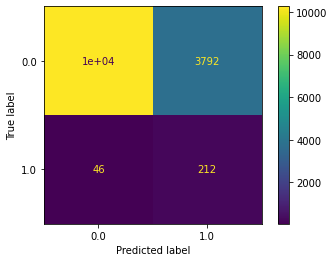

Accuracy:  73.2
F1-Score:  0.0995
Precision: 0.0529
Recall:    0.8217
MCC:       0.1636
AUC:       0.776
CPU times: user 553 ms, sys: 164 ms, total: 717 ms
Wall time: 538 ms


In [89]:
%%time
# Create classification model
linSVC = LinearSVC(class_weight='balanced',
                   max_iter=2500, random_state=42,
                   C=10, dual=False, loss='squared_hinge', 
                   penalty='l2', tol=1e-7)

# Fit model
linSVC.fit(X_train, y_train)

# Evaluate model
get_model_metrics('LinSVC', linSVC)

### Support Vector Classifier (SVC)

In [90]:
# Create classifier
svc = SVC(class_weight='balanced',
          random_state=42)

# Get a baseline model
baseline = svc.fit(X_train, y_train)

# Create range of candidate penalty hyperparameter values
parameter_space = {
    'kernel': ['linear'],# 'poly', 'rbf', 'sigmoid'] # follow up w/other params
    'C': [10, 100], #0.1, 1, 1000
    # 'gamma': ['scale', 'auto'],
    # 'shrinking': [True, False],
    # 'probability': [True, False],
    'tol': [1e-3, 1e-2]#, 1e-4, 0.1]
}
# Set up grid search
grid = GridSearchCV(svc, parameter_space, scoring=scoring, cv=5,
                    refit='MCC', return_train_score=True)
# grid = RandomizedSearchCV(svc, parameter_space, scoring=scoring, cv=5, 
#                           refit='MCC', return_train_score=True,
#                           n_iter=30, random_state=42)

In [91]:
%%time
# Fit models
grid_result = grid.fit(X_train, y_train)

CPU times: user 24min 17s, sys: 2.59 s, total: 24min 20s
Wall time: 24min 12s


In [92]:
# Show best parameters
print('Best parameters found:\n', grid_result.best_params_, '\n')
# Get accuracy scores
baseScore = round(baseline.score(X_test, y_test)*100, 2)
score = round(grid_result.score(X_test, y_test)*100, 2)
print(f"Baseline Accuracy:\t{baseScore}")
print(f"Tuned Accuracy:\t\t{score}")

Best parameters found:
 {'C': 100, 'kernel': 'linear', 'tol': 0.01} 

Baseline Accuracy:	75.75
Tuned Accuracy:		16.17


Evaluate tuned parameters

[[10213  3848]
 [   46   212]]


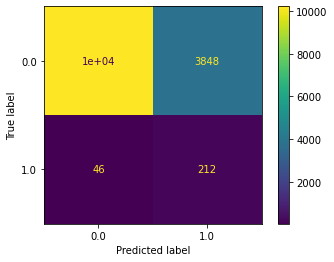

Accuracy:  72.81
F1-Score:  0.0982
Precision: 0.0522
Recall:    0.8217
MCC:       0.1617
AUC:       0.774
CPU times: user 1min 57s, sys: 183 ms, total: 1min 57s
Wall time: 1min 56s


In [93]:
%%time
# Create classification model
svc = SVC(class_weight='balanced',
          kernel='linear', C=100, tol=0.01,
          random_state=42)

# Fit model
svc.fit(X_train, y_train)

# Evaluate model
get_model_metrics('SVC', svc)

### Stochastic Gradient Descent

In [94]:
# Create classifier
sgd = SGDClassifier(class_weight='balanced',
                    max_iter=5000,
                    early_stopping=True,
                    random_state=42)

# Get a baseline model
baseline = sgd.fit(X_train, y_train)

# Create range of candidate penalty hyperparameter values
parameter_space = {
    'loss': ['hinge', 'log_loss', 'log', 'modified_huber', 'squared_hinge',
             'perceptron', 'squared_error', 'huber', 'epsilon_insensitive',
             'squared_epsilon_insensitive'],
    'penalty': ['l2', 'l1'],
    'alpha': [1e-5, 1e-4, 1e-3],
    'tol': [1e-7, 1e-5, 1e-3],
    'epsilon': [0.001, 0.01, 0.1],
    'learning_rate': ['constant', 'optimal', 'invscaling', 'adaptive']
}
# grid = GridSearchCV(sgd, parameter_space, scoring=mcc, cv=5)
# grid = RandomizedSearchCV(logit, parameter_space, cv=5, n_iter=30, random_state=42)
grid = GridSearchCV(sgd, parameter_space, scoring=scoring, cv=5,
                    refit='MCC', return_train_score=True)

In [6]:
# %%time
# # Fit models
# grid_result = grid.fit(X_train, y_train)

In [96]:
# Show best parameters
print('Best parameters found:\n', grid_result.best_params_, '\n')
# Get accuracy scores
baseScore = round(baseline.score(X_test, y_test)*100, 2)
score = round(grid_result.score(X_test, y_test)*100, 2)
print(f"Baseline Accuracy:\t{baseScore}")
print(f"Tuned Accuracy:\t\t{score}")

Best parameters found:
 {'alpha': 0.0001, 'epsilon': 0.01, 'learning_rate': 'optimal', 'loss': 'huber', 'penalty': 'l2', 'tol': 1e-07} 

Baseline Accuracy:	80.45
Tuned Accuracy:		15.3


Evaluate tuned parameters

[[9527 4534]
 [  35  223]]


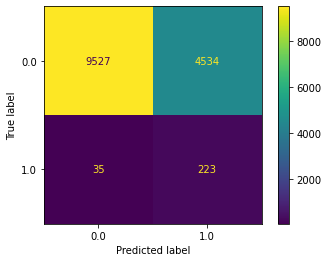

Accuracy:  68.09
F1-Score:  0.0889
Precision: 0.0469
Recall:    0.8643
MCC:       0.153
AUC:       0.7709
CPU times: user 400 ms, sys: 201 ms, total: 601 ms
Wall time: 403 ms


In [97]:
%%time
# Load libraries
from sklearn.linear_model import SGDClassifier

# Create classification model
sgd = SGDClassifier(class_weight='balanced',
                    alpha=0.0001, epsilon=0.01, learning_rate='optimal',
                    loss='huber', penalty='l2', tol=1e-7,
                    max_iter=2000,
                    early_stopping=True,
                    random_state=42)

# Fit model
sgd.fit(X_train, y_train)

# Evaluate model
get_model_metrics('SGD', sgd)

## Ensembles

### [Voting Classifier](https://scikit-learn.org/stable/modules/ensemble.html#voting-classifier)


In [98]:
from sklearn.ensemble import VotingClassifier
# split the full train set into train and validation sets
X_train_sub, X_val, y_train_sub, y_val = train_test_split(X_train, y_train, 
                                                          test_size=0.33, 
                                                          random_state=42)

In [99]:
# set up a collection of base models to include
def get_models():
	models = list()
	models.append(('LogReg', logit))
	models.append(('LinSVC', linSVC))
	models.append(('SVC', svc))
	models.append(('SGD', sgd)) 
	# models.append(('LGBM', lgbm)) 
	# models.append(('LDA', lda)) 
	# models.append(('GNB', nBayes)) 
	# models.append(('DT', decisiontree)) 
	# models.append(('KNN', knn)) 
	# models.append(('MLP', mlp)) 
	# models.append(('XGBC', xgbc)) 
	# models.append(('AdaB', adaboost)) 
	# models.append(('RF', rfClass)) 
	# models.append(('GBC', gbc)) 
 
	return models

#### Voting using AUC metric:

In [100]:
# evaluate each base model
def evaluate_models(models, X_train, X_val, y_train, y_val):
	# fit and evaluate the models
	scores = list()
	for name, model in models:
		# fit the model
		model.fit(X_train, y_train)
		# evaluate the model
		yhat = model.predict(X_val)
		auc = roc_auc_score(y_val, yhat, average='weighted')
		# store the performance
		scores.append(auc)
		# report model performance
	return scores

In [101]:
%%time 
# create the base models
models = get_models()
# fit and evaluate each model
scores = evaluate_models(models, X_train_sub, X_val, y_train_sub, y_val)
print(scores)
# create the ensemble
ensemble = VotingClassifier(estimators=models, voting='hard', weights=scores)
# fit the ensemble on the training dataset
ensemble.fit(X_train, y_train)
# make predictions on test set
yhat = ensemble.predict(X_test)
# evaluate predictions
score = roc_auc_score(y_test, yhat, average='weighted')
print('Weighted AUC: %.3f' % (score*100))

[0.7770317259780631, 0.7819073560682706, 0.7897198343182219, 0.7731051636076935]
Weighted AUC: 77.462
CPU times: user 2min 58s, sys: 929 ms, total: 2min 59s
Wall time: 2min 57s


[[10230  3831]
 [   46   212]]


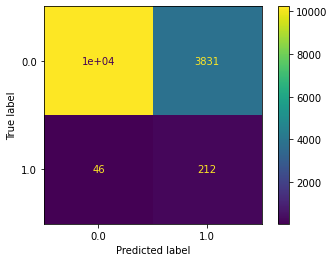

Accuracy:  72.92
F1-Score:  0.0986
Precision: 0.0524
Recall:    0.8217
MCC:       0.1623
AUC:       0.7746
CPU times: user 5.71 s, sys: 219 ms, total: 5.93 s
Wall time: 5.68 s


,Model,Accuracy,F1_Score,Precision,Recall,MCC,AUC
0,Ensemble_AUC,72.92,0.0986,0.0524,0.8217,0.1623,0.7746


In [102]:
%%time
# Evaluate model
get_model_metrics('Ensemble_AUC', ensemble)

#### Voting using Recall  metric:

In [103]:
# evaluate each base model
def evaluate_models(models, X_train, X_val, y_train, y_val):
	# fit and evaluate the models
	scores = list()
	for name, model in models:
		# fit the model
		model.fit(X_train, y_train)
		# evaluate the model
		yhat = model.predict(X_val)
		rec = recall_score(y_val, yhat)
		# store the performance
		scores.append(rec)
		# report model performance
	return scores

In [104]:
%%time 
# create the base models
models = get_models()
# fit and evaluate each model
scores = evaluate_models(models, X_train_sub, X_val, y_train_sub, y_val)
print(scores)
# create the ensemble
ensemble = VotingClassifier(estimators=models, voting='hard', weights=scores)
# fit the ensemble on the training dataset
ensemble.fit(X_train, y_train)
# make predictions on test set
yhat = ensemble.predict(X_test)
# evaluate predictions
score = recall_score(y_test, yhat)
print('Weighted Recall: %.3f' % (score*100))

[0.837696335078534, 0.8534031413612565, 0.8743455497382199, 0.7958115183246073]
Weighted Recall: 82.171
CPU times: user 3min 8s, sys: 1.01 s, total: 3min 9s
Wall time: 3min 7s


[[10290  3771]
 [   46   212]]


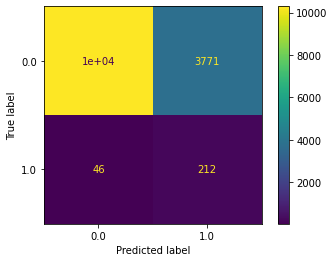

Accuracy:  73.34
F1-Score:  0.1
Precision: 0.0532
Recall:    0.8217
MCC:       0.1643
AUC:       0.7768
CPU times: user 5.71 s, sys: 227 ms, total: 5.93 s
Wall time: 5.68 s


,Model,Accuracy,F1_Score,Precision,Recall,MCC,AUC
0,Ensemble_Recall,73.34,0.1,0.0532,0.8217,0.1643,0.7768


In [105]:
%%time
# Evaluate model
get_model_metrics('Ensemble_Recall', ensemble)

#### Voting using Matthews Correlation Coefficient metric:

In [106]:
# evaluate each base model
def evaluate_models(models, X_train, X_val, y_train, y_val):
	# fit and evaluate the models
	scores = list()
	for name, model in models:
		# fit the model
		model.fit(X_train, y_train)
		# evaluate the model
		yhat = model.predict(X_val)
		mcc = matthews_corrcoef(y_val, yhat)
		# store the performance
		scores.append(mcc)
		# report model performance
	return scores

In [107]:
%%time 
# create the base models
models = get_models()
# fit and evaluate each model
scores = evaluate_models(models, X_train_sub, X_val, y_train_sub, y_val)
print(scores)
# create the ensemble
ensemble = VotingClassifier(estimators=models, voting='hard', weights=scores)
# fit the ensemble on the training dataset
ensemble.fit(X_train, y_train)
# make predictions on test set
yhat = ensemble.predict(X_test)
# evaluate predictions
score = matthews_corrcoef(y_test, yhat)
print('Weighted MCC: %.3f' % (score*100))

[0.16976509962266212, 0.17172819907162, 0.17556707027792468, 0.17384030721868218]
Weighted MCC: 16.177
CPU times: user 3min 5s, sys: 923 ms, total: 3min 6s
Wall time: 3min 8s


[[10214  3847]
 [   46   212]]


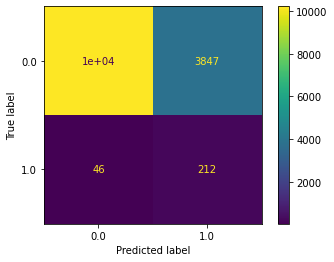

Accuracy:  72.81
F1-Score:  0.0982
Precision: 0.0522
Recall:    0.8217
MCC:       0.1618
AUC:       0.7741
CPU times: user 5.73 s, sys: 208 ms, total: 5.94 s
Wall time: 5.73 s


,Model,Accuracy,F1_Score,Precision,Recall,MCC,AUC
0,Ensemble_MCC,72.81,0.0982,0.0522,0.8217,0.1618,0.7741


In [108]:
%%time
# Evaluate model
get_model_metrics('Ensemble_MCC', ensemble)

### Stacking Classifier

In [109]:
%%time
# set up estimmator for classifier
final_estimator = LogisticRegression(class_weight='balanced')
# create the ensemble
stk = StackingClassifier(
    estimators=models,
    final_estimator=final_estimator
)
# fit the model
stk.fit(X_train, y_train)

CPU times: user 8min 29s, sys: 2.67 s, total: 8min 32s
Wall time: 8min 27s


[[10296  3765]
 [   48   210]]


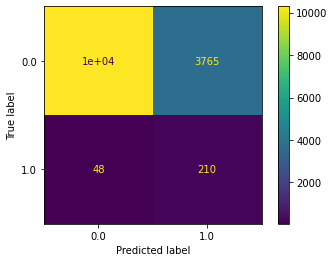

Accuracy:  73.37
F1-Score:  0.0992
Precision: 0.0528
Recall:    0.814
MCC:       0.1622
AUC:       0.7731
CPU times: user 5.56 s, sys: 231 ms, total: 5.79 s
Wall time: 5.54 s


,Model,Accuracy,F1_Score,Precision,Recall,MCC,AUC
0,Stacking,73.37,0.0992,0.0528,0.814,0.1622,0.7731


In [110]:
%%time
# evaluate model
get_model_metrics('Stacking', stk)

### Bagging Classifier

[[10399  3662]
 [   48   210]]


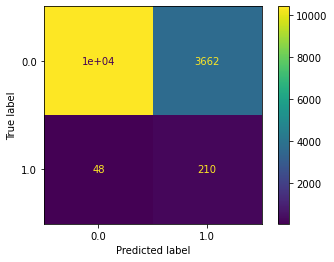

Accuracy:  74.09
F1-Score:  0.1017
Precision: 0.0542
Recall:    0.814
MCC:       0.1658
AUC:       0.7768
CPU times: user 2.46 s, sys: 111 ms, total: 2.57 s
Wall time: 2.62 s


In [111]:
%%time 
# create the ensemble and fit model
clf = BaggingClassifier(base_estimator=logit, n_estimators=10,
                        random_state=42).fit(X_train, y_train)
# evaluate model
get_model_metrics('Ensemble_bag', clf)                    